<div>
<h1>Run the cell below to generate the road map (do not modify it)</h1></div>

In [1]:
%%javascript
var kernel = IPython.notebook.kernel;var thename = window.document.getElementById("notebook_name").innerHTML;var command = "THE_NOTEBOOK = " + "'"+thename+"'";kernel.execute(command);command="os.environ['THE_NOTEBOOK'] = THE_NOTEBOOK";kernel.execute(command);var cell = IPython.notebook.get_cell(2);cell.execute();IPython.notebook.get_cell(3).focus_cell();var x = $('.code_cell');$(x[1]).children('.input').hide();

<IPython.core.display.Javascript object>

In [2]:
outputdir = "/tmp/tools/"
!mkdir -p $outputdir
!wget "https://www.dropbox.com/s/4g0pigmro4vo1b4/menutemplate?dl=0" -O /tmp/tools/menutemplate >> /tmp/toollog 2>&1 
!wget "https://www.dropbox.com/s/3flttpzhsja8td7/construct_menu.py?dl=0" -O /tmp/tools/construct_menu.py >> /tmp/toollog 2>&1 
!python /tmp/tools/construct_menu.py "{THE_NOTEBOOK}.ipynb" {outputdir}
from IPython.core.display import HTML
output_file_name = outputdir + THE_NOTEBOOK.replace(" ", "").replace("[", "").replace("]", "") + ".ipynb.html"
with open(output_file_name) as fp:
    html = fp.read()
HTML(html)

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well known clustering algorithm to detect anomaly network connections based on statistics about each of them. For a thorough overview of K-means clustering, from a research perspective, have a look at this wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unsual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measue the similarity between any two data points, K-means requires the definition of a distance funtion between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work ?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centres of those runs and input the centres as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 1

#### Question 1.1
Complete the below function to calculate an euclidean distance between any two points in $d$-dimensional data space

In [73]:

import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p2)-np.array(p1))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"


<div class='anchor' ></div>

#### Question 1.2
Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

In [145]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    centroids=np.array(centroids)
    datapoint=np.array(datapoint)
    distances=[euclidean_distance(datapoint, centroids[i]) for i in range(len(centroids))]
    return np.argmin(distances)
assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"


<div class='anchor' ></div>

#### Question 1.3
Write a function to randomize $k$ initial centroids.

In [197]:
np.random.seed(22324)
# randomize initial centroids
def randomize_centroids(data, k):
    data=np.array(data)
    indices=np.random.randint(len(data), size=k)
    centroids = data[indices] 
    return centroids

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"


<div class='anchor' ></div>

#### Question 1.4
Write function `check_converge` to check the stop creteria of the algorithm.

In [198]:
MAX_ITERATIONS = 100

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if(num_iterations>=MAX_ITERATIONS):
      return True
    # check if the centroids don't move (or very slightly)
    distances=list(map(lambda x,y:euclidean_distance(x,y)),centroids,old_centroids)
    sm=np.sum(np.array(distances)*np.array(distances))
    if(sm<=treshold):
      return True
    else:
      return False


<div class='anchor' ></div>

#### Question 1.5
Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

In [199]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    centroids=[[]for i in range(len(cluster))]
    for i in range(len(centroids)):
        centroids[i]=np.mean(np.array(cluster[i]),axis=0)       
    return centroids


<div class='anchor' ></div>

#### Question 1.6
Complete the K-means algorithm scheleton below, with the functions you wrote above.

In [205]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroidshich
num_iterations=100
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)
    old_centroids = centroids[:]
    iterations = 0
    while True:
        iterations += 1
        # init empty clusters
        clusters = [[] for i in range(k)]
        # assign each data point to the closest centroid
        for datapoint in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(datapoint, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(datapoint)
        # keep the current position of centroids before changing them
        old_centroids = centroids
        # update centroids
        centroids = update_centroids(centroids,clusters)
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, num_iterations, threshold=0):
            break
    return centroids


Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

<div class='anchor' ></div>

#### Question 1.7
The code below can be used to test your algorithm with three different datasets: Iris, Moon and Blob.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


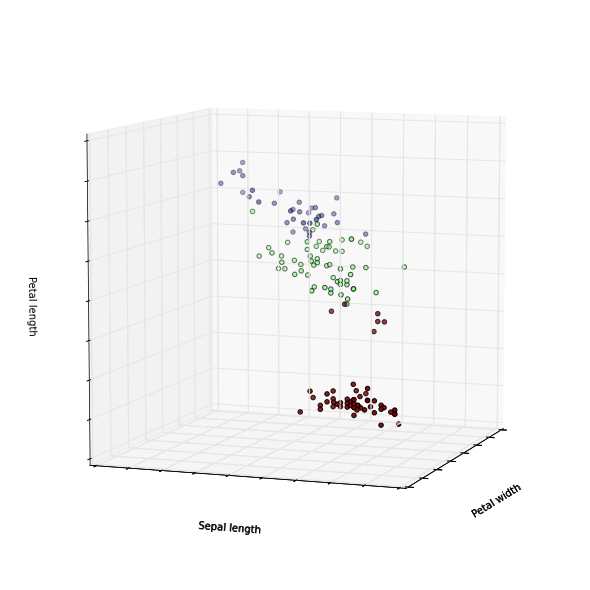

In [209]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
#print(len(y_iris))
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]
#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

# moon
# np.random.seed(0)
# X, y = datasets.make_moons(2000, noise=0.2)

# blob
# np.random.seed(0)cluster[0]
# X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

# centers = kmeans(X, k=3)
# labels = [find_closest_centroid(p, centers) for p in X]

# fig = plt.figure(1, figsize=(8, 8))
# plt.clf()
# plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.show()
# Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3load_iris)
# centers.fit(X_iris) 
# labels = centers2.labels_


<div class="comment">

When running the program many times we have whole different clusters, this is a sign of bad performance of the algorithm because it gets stuck in local optimas depending on the random initialization of the algorithm. To verify this we can plot the labels we have in the data (although this is a clustering algorithm , but we see that we have them in the code).To solve this issue we can run the k-mean algorithm many times with random initialisations and then take the initial positions of centroids that perform best , which is what we propose to do next.

</div>

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


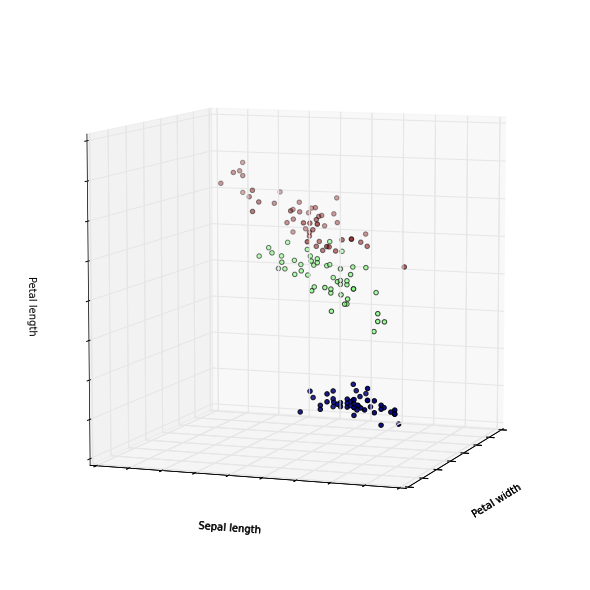

In [210]:

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=y_iris)

# moon
# np.random.seed(0)
# X, y = datasets.make_moons(2000, noise=0.2)

# blob
# np.random.seed(0)
# X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

# centers = kmeans(X, k=3)X_iris
# labels = [find_closest_centroid(p, centers) for p in X]

# fig = plt.figure(1, figsize=(8, 8))
# plt.clf()
# plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
plt.show()

<div class="comment">
We see that the real clusters are actually different from the ones we predicted since flower classes do not really cluster separatly according to Petal length,Sepal length and Petal width as we would wish. 
</div>

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


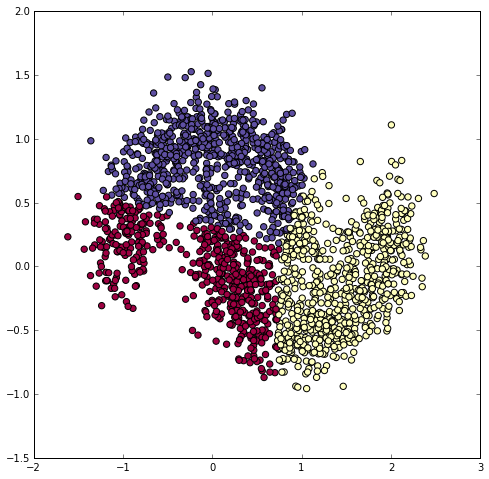

In [211]:
# moon
np.random.seed(0)
X, y = datasets.make_moons(2000, noise=0.2)
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


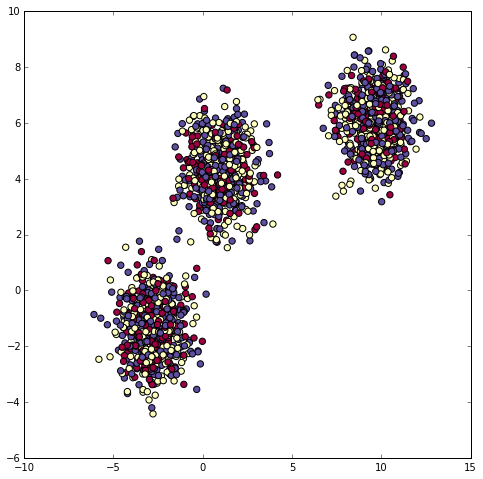

In [189]:
# blob
np.random.seed(0)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each features, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [160]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase !!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 2
Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [170]:
def parseLine(line):
    cols = line.split(',')
    # label is the last column	source code
    
    label = cols[-1:]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector=vector[0]+vector[4:]
    
    # convert each value from string to float
    vector = np.array(vector)
    vector = vector.astype(np.float)
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.map(lambda x: x[1]).cache()

# number of connections
n = data


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 3
Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

You can use the following parameters:

* `maxIterations=10`
* `runs=10`
* `initializationMode="random"`

Discuss the result from your figure.

```python
clusters = KMeans....
```

<div class="answer">


PUT YOUR ANSWER HERE !!!


</div>

### 2.2.3. Evaluating model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 4

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.


```python
from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = ...
    return ...

WSSSE = data.map(...).reduce(...)
print("Within Set Sum of Squared Error = " + str(WSSSE))
```

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 5
This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.
What do you think about the result ?

```python
clusterLabelCount = ...

for item in clusterLabelCount:
    print(item)
```

<div class='comment' >

PUT YOUR COMMENT HERE

</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 6
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.
Plot the results. From the obtained result, what is the best value for $k$ ? Why ?

```python
# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans....
    # calculate mean square error
    return ...

scores = ...
for score in scores:
    print(score)
    
# plot results
plt...
```

<div class="answer">

PUT YOUR ANSWER HERE !

</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
#### Question 7

Complete the code below to normalize the data. Print the first 5 lines of the new data.

HINT: If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

```python
def normalizeData(data):
    # number of connections
    n = ...

    # calculate the sum of each feature
    sums = ...
    print(sums)

    # calculate means
    means = ...

    # calculate the sum square of each feature
    sumSquares = ...
    print(sumSquares)

    # calculate standard deviation of each feature
    stdevs = ...
    print(stdevs)

    def normalize(point):
        return ...

    return data.map(normalize)

normalizedData = normalizeData(data).cache()
print(normalizedData.take(5))
```

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 8
Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

```python
scores = ...
for score in scores:
    print(score)

plt...
```

<div class='answer'>

PUT YOUR ANSWER HERE !!!

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 9
Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

<div class="comment">


PUT YOUR ANSWER HERE !!!

</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, substraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical features into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorial feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping mapping **one** categorial feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 10
Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

```python
def parseLineWithHotEncoding(line):
    cols = line...
    # label is the last column
    label = ...
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorial feature
    featureOfCol1 = ...
    # the binary features that are encoded from the second categorial feature
    featureOfCol2 = ...
    # the binary features that are encoded from the third categorial feature
    featureOfCol3 = ...
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(...)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()


normalizedData = normalizeData(data).cache()
```

### 2.3.2. Building models

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
#### Question 11
Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

```python
scores = list(...)
plt....
```

<div class="answer">


PUT YOUR ANSWER HERE !!!


</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide wheter there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 12
Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

HINT: The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 13
Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

Here are some additional information about the metrics we suggest to use:
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

Note: you are free to play with any relevant evaluation metric you think appropriate for your work!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

#### Question 14
Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a "map/reduce" algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.